In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torchattacks
import torchvision
from torchvision import transforms

In [2]:
from biotorch.datasets.cifar import CIFAR10Benchmark
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch 

In [3]:
dataset = CIFAR10Benchmark(32, test_transforms=[
    transforms.transforms.Resize((32, 32)),
    transforms.ToTensor()])

cifar_mean = (0.4914, 0.4821, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

train_dataloader = dataset.create_train_dataloader(128)
val_dataloader = dataset.create_val_dataloader(128)
test_dataloader = dataset.create_test_dataloader(128)

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
model_fa = torch.load('trained_models/experiment_CIFAR10_Benchmark_FA_resnet20_final/model_best_acc.pth')
model_fa = add_data_normalization(model_fa, cifar_mean, cifar_std).eval()
model_bp = torch.load('trained_models/experiment_CIFAR10_Benchmark_backpropagaation_resnet20/model_best_acc.pth')
model_bp = add_data_normalization(model_bp, cifar_mean, cifar_std).eval()
model_sign = torch.load('trained_models/experiment_CIFAR10_Benchmark_sign_1_resnet20_final_10/model_best_acc.pth')
model_sign = add_data_normalization(model_sign, cifar_mean, cifar_std).eval()
model_dfa = torch.load('trained_models/experiment_CIFAR10_Benchmark_DFA_resnet20_final_final/model_best_acc.pth')
model_dfa = add_data_normalization(model_dfa, cifar_mean, cifar_std).eval()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [10]:
from torchattacks import SparseFool, Square, OnePixel

## Small Epsilons

In [17]:
epsilons = [0.0]

In [ ]:
attack = SparseFool(model_bp, steps=10, lam=1, overshoot=0.02)
model_bp = model_bp.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(model_bp, test_dataloader, 
                                                                attack, epsilons, device, verbose=True)

Clean accuracy:  0.9130736
Epsilon:  0.0


  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
robust_accuracy_bp

In [94]:
attack = FGSM(model_fa, eps=1/255)
model_fa = model_fa.to(device)
clean_accuracy_fa, robust_accuracy_fa = apply_attack_on_dataset(model_fa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6704905


In [95]:
attack = FGSM(model_dfa, eps=1/255, mode='DFA')
model_dfa = model_dfa.to(device)
clean_accuracy_dfa, robust_accuracy_dfa = apply_attack_on_dataset(model_dfa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6538766


In [102]:
attack = FGSM(model_sign, eps=1/255)
model_sign = model_sign.to(device)
clean_accuracy_sign, robust_accuracy_sign = apply_attack_on_dataset(model_sign, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.8503758


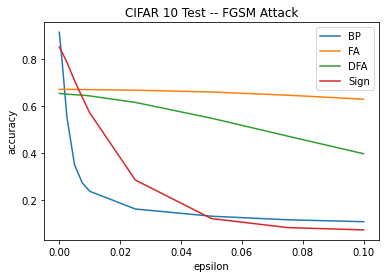

In [103]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp,
                  robust_accuracy_fa, 
                  robust_accuracy_dfa, 
                  robust_accuracy_sign,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

## Big epsilons

In [75]:
epsilons = [0.0, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.75, 0.9, 1]

In [76]:
attack = FGSM(model_bp, eps=1/255)
model_bp = model_bp.to(device)
clean_accuracy_bp, robust_accuracy_bp = apply_attack_on_dataset(model_bp, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.9130736


In [77]:
attack = FGSM(model_fa, eps=1/255)
model_fa = model_fa.to(device)
clean_accuracy_fa, robust_accuracy_fa = apply_attack_on_dataset(model_fa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6704905


In [78]:
attack = FGSM(model_dfa, eps=1/255, mode='DFA')
model_dfa = model_dfa.to(device)
clean_accuracy_dfa, robust_accuracy_dfa = apply_attack_on_dataset(model_dfa, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.6538766


In [79]:
attack = FGSM(model_sign, eps=1/255)
model_sign = model_sign.to(device)
clean_accuracy_sign, robust_accuracy_sign = apply_attack_on_dataset(model_sign, test_dataloader, 
                                                                attack, epsilons, device, verbose=False)

Clean accuracy:  0.84483784


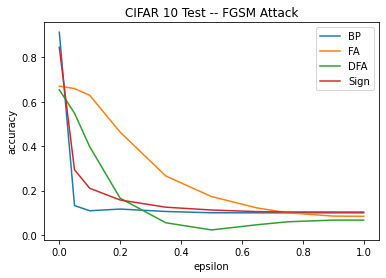

In [80]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp,
                  robust_accuracy_fa, 
                  robust_accuracy_dfa, 
                  robust_accuracy_sign,
                            ], 
              ['BP', 'FA', 'DFA', 'Sign'],
              'CIFAR 10 Test -- FGSM Attack',
             'epsilon')

In [47]:
images, labels = iter(test_dataloader).next()

Clean Accuracy on Batch: 0.9296875%
Robust Accuracy on Batch: 0.3359375%


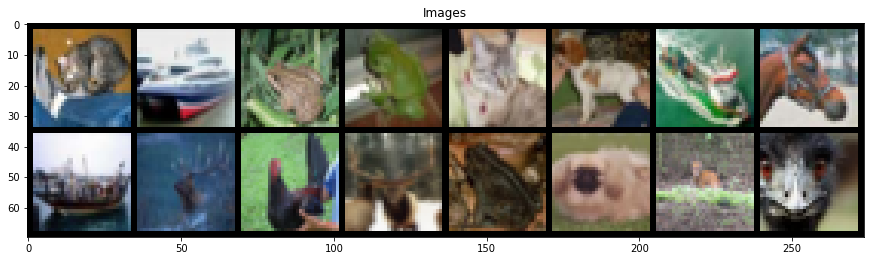

In [48]:
attack = SparseFool(model_bp, steps=20, lam=3, overshoot=0.1)
# attack = Square(model_bp, eps=0.005)
model_bp = model_bp.to(device)
adv_images, success, accuracy_clean, accuracy_robust = apply_attack_on_batch(model_bp, images, labels, attack, device)
plot_images = images[success]
plot_images_adv = adv_images[success]
imshow(torchvision.utils.make_grid(plot_images[0:16], normalize=False), "Images")

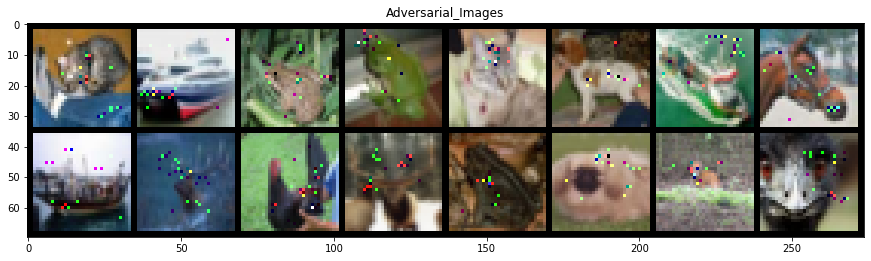

In [49]:
imshow(torchvision.utils.make_grid(plot_images_adv[0:16], normalize=False), "Adversarial_Images")

In [54]:
image_distance(plot_images[0], plot_images_adv[0], 'l0')

tensor(0.0038)

In [56]:
torch.count_nonzero(plot_images[0] - plot_images_adv[0])

tensor(26)

In [57]:
torch.count_nonzero(plot_images[1] - plot_images_adv[1])

tensor(30)

In [62]:
torch.count_nonzero(plot_images[2] - plot_images_adv[2])

tensor(25)

In [63]:
torch.count_nonzero(plot_images[3] - plot_images_adv[3])

tensor(25)

In [64]:
torch.count_nonzero(plot_images[4] - plot_images_adv[4])

tensor(24)

In [61]:
26/(32*32) * 100

2.5390625

In [60]:
32*32

1024

Clean Accuracy on Batch: 0.71875%
Robust Accuracy on Batch: 0.421875%


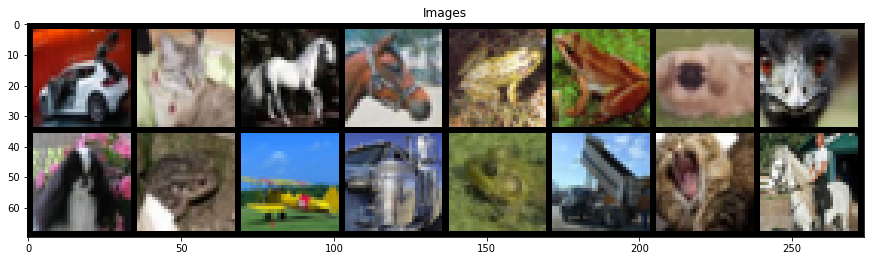

In [65]:
attack = SparseFool(model_fa, steps=20, lam=3, overshoot=0.1)
# attack = Square(model_fa, eps=0.005)
model_fa = model_fa.to(device)
adv_images, success, accuracy_clean, accuracy_robust = apply_attack_on_batch(model_fa, images, labels, attack, device)
plot_images = images[success]
plot_images_adv = adv_images[success]
imshow(torchvision.utils.make_grid(plot_images[0:16], normalize=False), "Images")

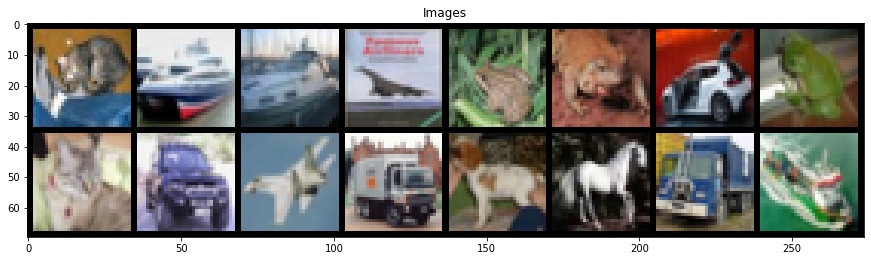

In [76]:
imshow(torchvision.utils.make_grid(images[0:16], normalize=False), "Images")

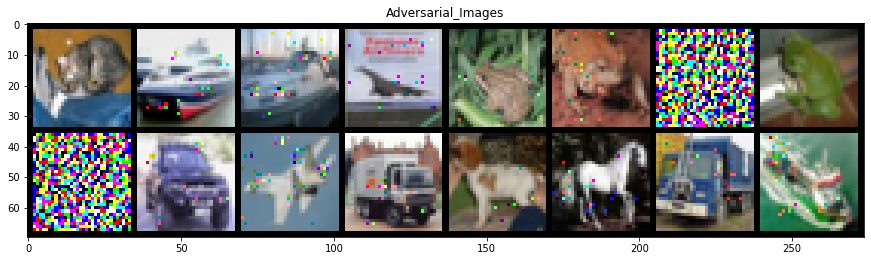

In [78]:
imshow(torchvision.utils.make_grid(adv_images[0:16], normalize=False), "Adversarial_Images")

In [72]:
image_distance(plot_images[1], plot_images_adv[1], 'l0')

tensor(0.4989)

In [71]:
torch.count_nonzero(plot_images[1] - plot_images_adv[1])

tensor(3072)

38

In [31]:
plot_images_adv

tensor([[[[0.0852, 0.0695, 0.0874,  ..., 0.7793, 0.7854, 0.7675],
          [0.0952, 0.0795, 0.0874,  ..., 0.8089, 0.8050, 0.7872],
          [0.0952, 0.0834, 0.0952,  ..., 0.8325, 0.8207, 0.8028],
          ...,
          [0.7558, 0.6891, 0.6952,  ..., 0.5893, 0.5854, 0.5479],
          [0.6695, 0.6107, 0.6521,  ..., 0.5440, 0.5893, 0.5911],
          [0.5872, 0.5205, 0.5697,  ..., 0.5793, 0.6128, 0.5832]],

         [[0.0695, 0.0774, 0.0577,  ..., 0.6028, 0.5911, 0.5972],
          [0.0734, 0.0734, 0.0617,  ..., 0.6538, 0.6381, 0.6442],
          [0.0734, 0.0734, 0.0734,  ..., 0.6734, 0.6577, 0.6560],
          ...,
          [0.7636, 0.6970, 0.6970,  ..., 0.5087, 0.5048, 0.4874],
          [0.6891, 0.6264, 0.6617,  ..., 0.4734, 0.5048, 0.5305],
          [0.6107, 0.5440, 0.5872,  ..., 0.5126, 0.5323, 0.5226]],

         [[0.0852, 0.1148, 0.0795,  ..., 0.4952, 0.4734, 0.4656],
          [0.0891, 0.1009, 0.0734,  ..., 0.5166, 0.5009, 0.4970],
          [0.0891, 0.0970, 0.0852,  ..., 0

In [42]:
def image_distance(im1, im2, distance):
    if distance == 'l2':
        return torch.dist(im1, im2)
    elif distance == 'l0':
        return torch.mean(torch.abs(im1-im2))
    

In [46]:
image_distance(plot_images[2], plot_images_adv[2], 'l2')

tensor(0.2767)

In [39]:
torch.dist(plot_images[3], plot_images_adv[3])

tensor(3071.)